
# Student Performance Prediction Using Machine Learning

## Objective
Predict student dropout risk using supervised machine learning models to support early academic intervention.

## Dataset
- 649 student records
- 33 features including academic and demographic indicators

## Models Used
- Random Forest
- Neural Network

## Evaluation Focus
Accuracy and recall, with emphasis on improving dropout detection.


## Data Loading and Initial Exploration

In [ ]:
# 1) Imports and Setup
# ======================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# Classification models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# SMOTE
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42


## Data Preprocessing and Feature Engineering

In [ ]:
# 2) Data Loading
# ======================
from zipfile import ZipFile
import requests
from io import BytesIO

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
response = requests.get(url)
zip_file = ZipFile(BytesIO(response.content))
zip_file.extractall("/content/")

df = pd.read_csv('student-por.csv', sep=';')
print("Initial shape:", df.shape)
display(df.head())

Initial shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Dimensionality Reduction and Class Imbalance Handling

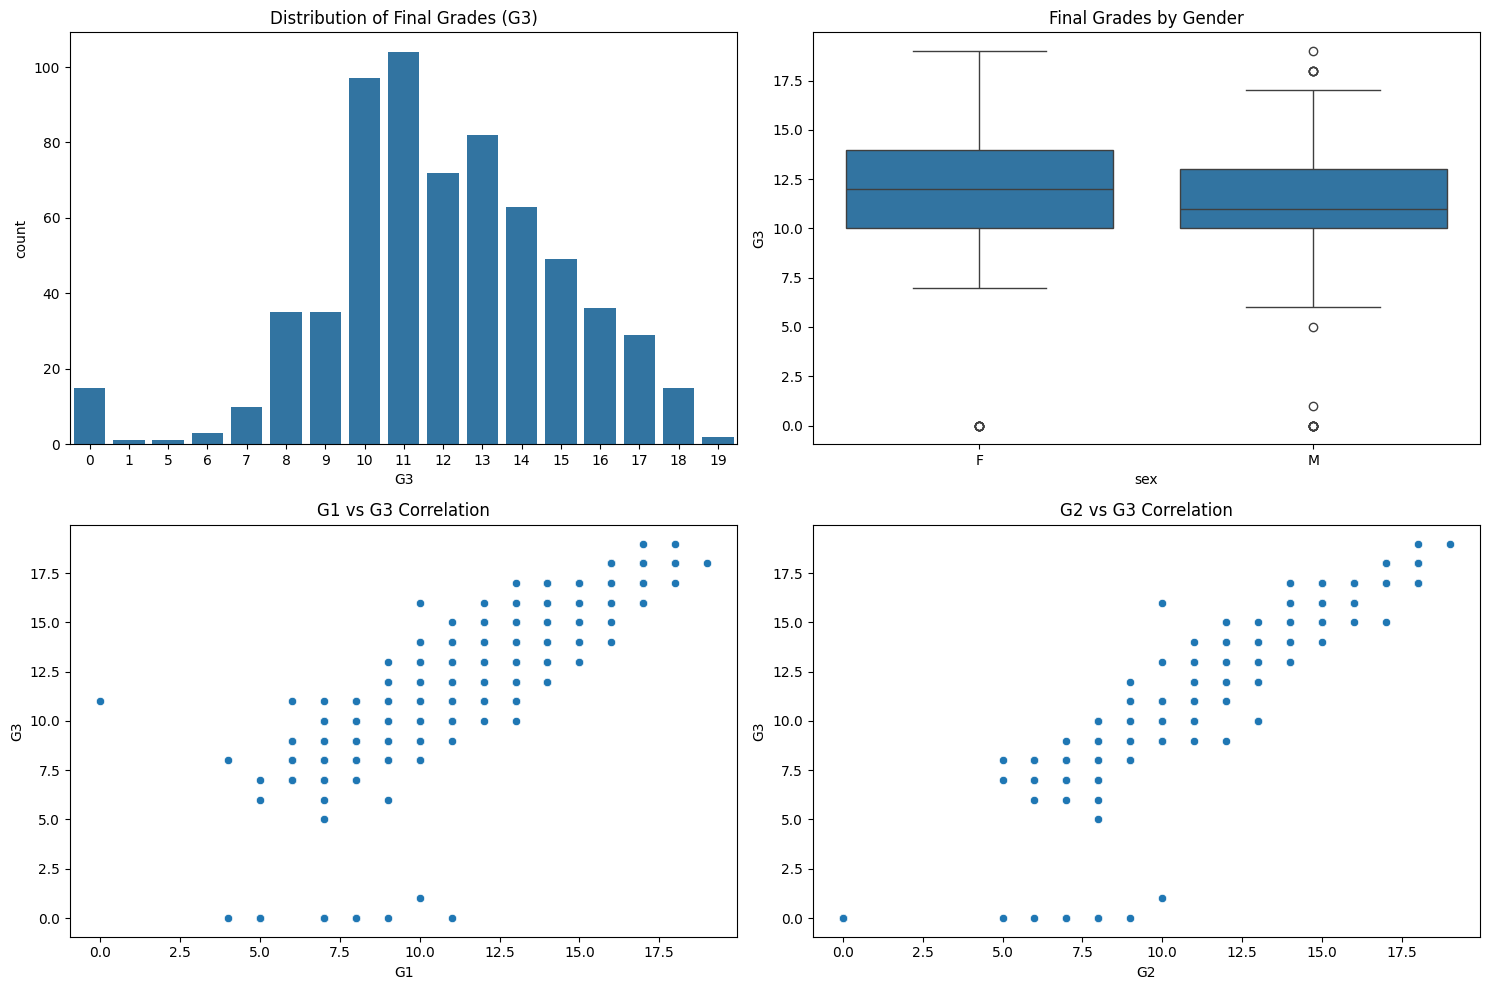

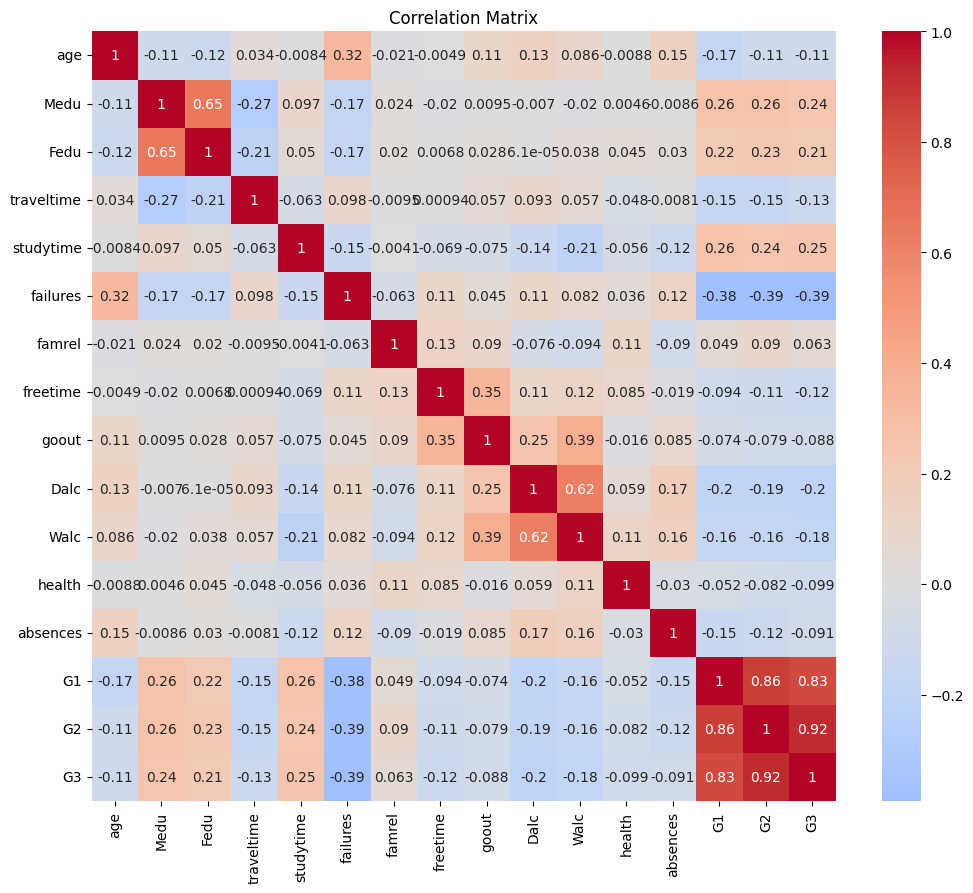

In [ ]:
# 3) Exploratory Data Analysis (EDA)
# ======================
plt.figure(figsize=(15, 10))

# Target variable distribution
plt.subplot(2,2,1)
sns.countplot(x='G3', data=df)
plt.title('Distribution of Final Grades (G3)')

plt.subplot(2,2,2)
sns.boxplot(x='sex', y='G3', data=df)
plt.title('Final Grades by Gender')

plt.subplot(2,2,3)
sns.scatterplot(x='G1', y='G3', data=df)
plt.title('G1 vs G3 Correlation')

plt.subplot(2,2,4)
sns.scatterplot(x='G2', y='G3', data=df)
plt.title('G2 vs G3 Correlation')

plt.tight_layout()
plt.show()

# Correlation matrix
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

## Model Training

Feature count: 30
Original dims: 30 -> PCA dims: 27


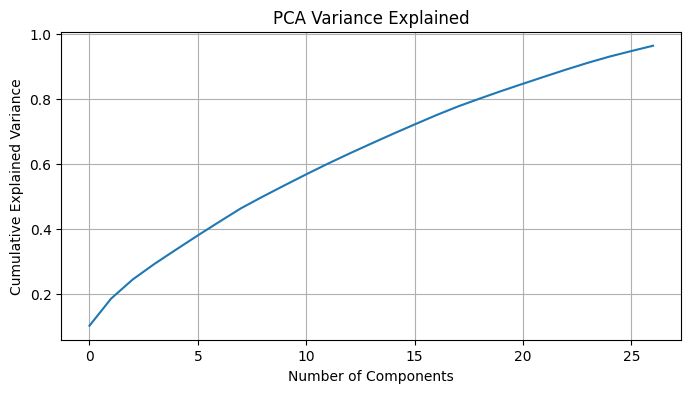

In [ ]:
# 4) Data Preprocessing
# ======================
# Create classification targets
df['pass'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)
df['dropout'] = df['G3'].apply(lambda x: 1 if x <= 5 else 0)

# Label-encode categorical features
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Features to use
features = df.drop(columns=['G1','G2','G3','pass','dropout']).columns.tolist()
print("Feature count:", len(features))

X = df[features].copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
print("Original dims:", X.shape[1], "-> PCA dims:", X_pca.shape[1])

# PCA Variance Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid()
plt.show()

## Model Evaluation

In [ ]:
# 5) Model Definitions
# ======================
classification_models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64,32), max_iter=2000, random_state=RANDOM_STATE)
}

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
    "Neural Network Regressor": MLPRegressor(hidden_layer_sizes=(64,32), max_iter=2000, random_state=RANDOM_STATE)
}


In [ ]:
# 6) Classification with SMOTE
# ======================
def run_classification_with_smote(X_pca, y, models_dict, n_splits=10, random_state=RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {name: {"accuracy": [], "precision": [], "recall": [], "f1": [], "conf_matrices": []} for name in models_dict}

    fold = 0
    for train_idx, test_idx in skf.split(X_pca, y):
        fold += 1
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # SMOTE only on training set
        sm = SMOTE(random_state=random_state)
        X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

        for name, model in models_dict.items():
            model.fit(X_train_sm, y_train_sm)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            cm = confusion_matrix(y_test, y_pred)

            results[name]["accuracy"].append(acc)
            results[name]["precision"].append(prec)
            results[name]["recall"].append(rec)
            results[name]["f1"].append(f1)
            results[name]["conf_matrices"].append(cm)
    return results

# Run classification tasks
y_pass = df['pass']
y_dropout = df['dropout']

print("\nRunning Pass/Fail classification (10-fold CV + SMOTE)...")
res_pass = run_classification_with_smote(X_pca, y_pass, classification_models)

print("\nRunning Dropout classification (10-fold CV + SMOTE)...")
res_dropout = run_classification_with_smote(X_pca, y_dropout, classification_models)



Running Pass/Fail classification (10-fold CV + SMOTE)...

Running Dropout classification (10-fold CV + SMOTE)...



=== Summary for Pass/Fail ===

Logistic Regression:
 Accuracy:  0.7812
 Precision: 0.9334
 Recall:    0.7997
 F1-score:  0.8598


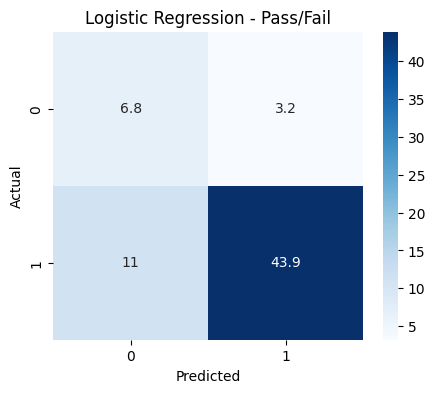


Decision Tree:
 Accuracy:  0.7458
 Precision: 0.8884
 Recall:    0.7997
 F1-score:  0.8406


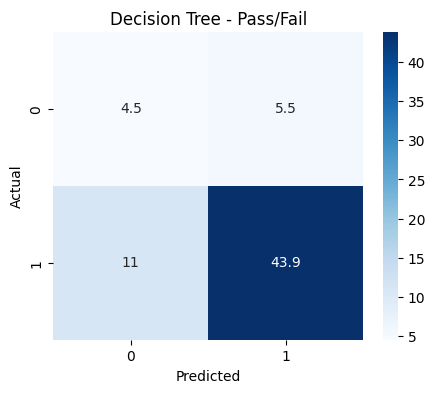


Random Forest:
 Accuracy:  0.8505
 Precision: 0.8975
 Recall:    0.9308
 F1-score:  0.9132


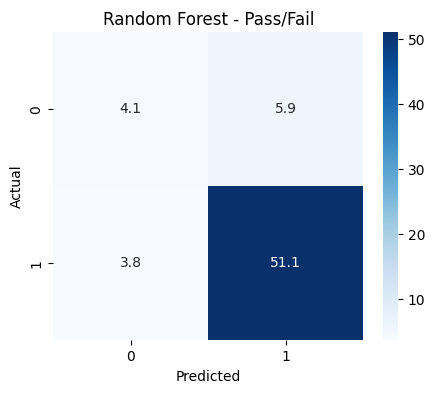


Naive Bayes:
 Accuracy:  0.7906
 Precision: 0.9228
 Recall:    0.8235
 F1-score:  0.8687


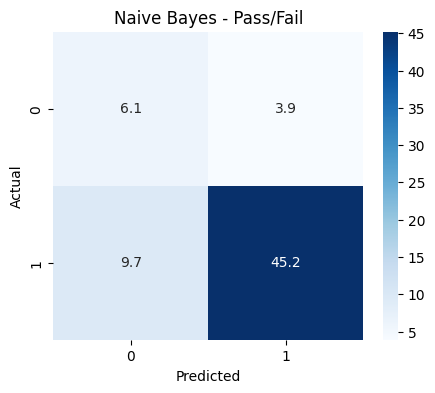


Neural Network:
 Accuracy:  0.8305
 Precision: 0.8958
 Recall:    0.9053
 F1-score:  0.9003


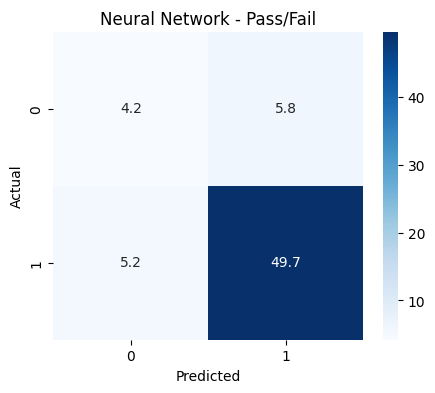


=== Summary for Dropout ===

Logistic Regression:
 Accuracy:  0.9245
 Precision: 0.1589
 Recall:    0.4500
 F1-score:  0.2299


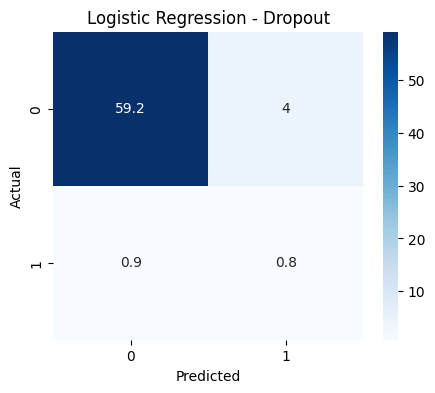


Decision Tree:
 Accuracy:  0.9352
 Precision: 0.1125
 Recall:    0.1500
 F1-score:  0.0889


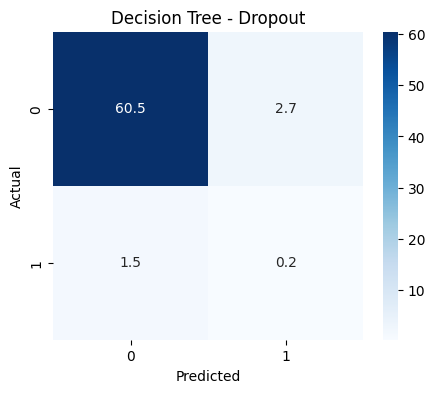


Random Forest:
 Accuracy:  0.9707
 Precision: 0.0500
 Recall:    0.0500
 F1-score:  0.0500


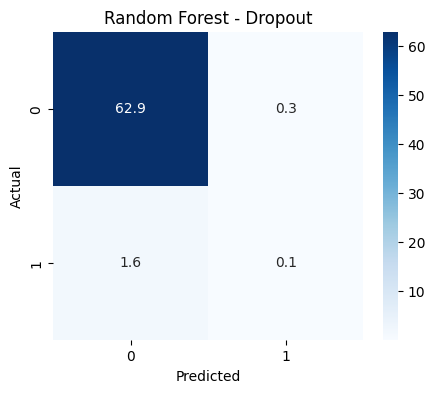


Naive Bayes:
 Accuracy:  0.9384
 Precision: 0.0700
 Recall:    0.1500
 F1-score:  0.0936


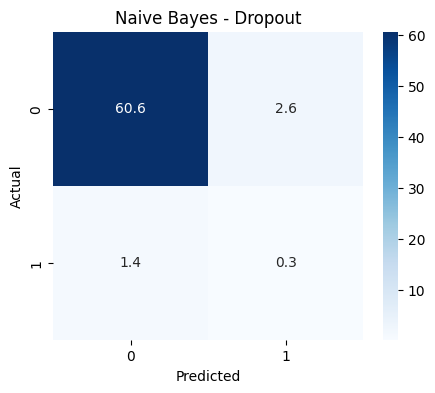


Neural Network:
 Accuracy:  0.9615
 Precision: 0.1500
 Recall:    0.1500
 F1-score:  0.1500


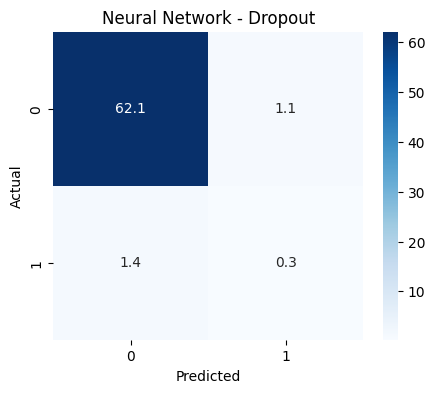

,task,model,accuracy,precision,recall,f1,cm00,cm01,cm10,cm11
0,Pass/Fail,Logistic Regression,0.781178,0.933430,0.799731,0.859775,6.8,3.2,11.0,43.9
1,Pass/Fail,Decision Tree,0.745793,0.888429,0.799731,0.840561,4.5,5.5,11.0,43.9
2,Pass/Fail,Random Forest,0.850529,0.897465,0.930842,0.913170,4.1,5.9,3.8,51.1
3,Pass/Fail,Naive Bayes,0.790553,0.922751,0.823535,0.868662,6.1,3.9,9.7,45.2
4,Pass/Fail,Neural Network,0.830481,0.895794,0.905286,0.900322,4.2,5.8,5.2,49.7
5,Dropout,Logistic Regression,0.924543,0.158889,0.450000,0.229935,59.2,4.0,0.9,0.8
6,Dropout,Decision Tree,0.935216,0.112500,0.150000,0.088889,60.5,2.7,1.5,0.2
7,Dropout,Random Forest,0.970721,0.050000,0.050000,0.050000,62.9,0.3,1.6,0.1
8,Dropout,Naive Bayes,0.938365,0.070000,0.150000,0.093571,60.6,2.6,1.4,0.3
9,Dropout,Neural Network,0.961490,0.150000,0.150000,0.150000,62.1,1.1,1.4,0.3


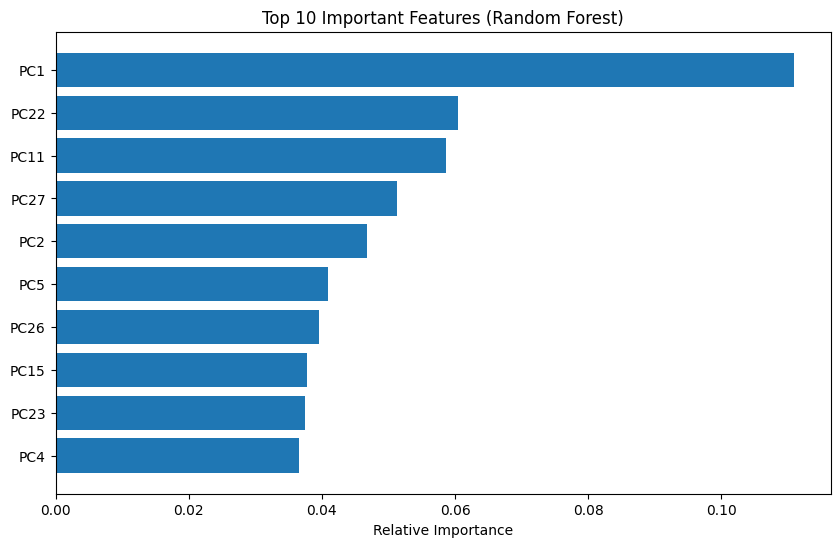

In [ ]:
# 7) Classification Results
# ======================
def summarize_classification_results(results, task_name):
    summary_rows = []
    print(f"\n=== Summary for {task_name} ===")
    for name, metrics in results.items():
        acc_mean = np.mean(metrics['accuracy'])
        prec_mean = np.mean(metrics['precision'])
        rec_mean = np.mean(metrics['recall'])
        f1_mean = np.mean(metrics['f1'])
        cms = np.array(metrics['conf_matrices'])
        avg_cm = np.mean(cms, axis=0)

        print(f"\n{name}:")
        print(f" Accuracy:  {acc_mean:.4f}")
        print(f" Precision: {prec_mean:.4f}")
        print(f" Recall:    {rec_mean:.4f}")
        print(f" F1-score:  {f1_mean:.4f}")

        # Plot confusion matrix
        plt.figure(figsize=(5,4))
        sns.heatmap(avg_cm.round(2), annot=True, fmt='g', cmap='Blues')
        plt.title(f'{name} - {task_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        summary_rows.append({
            "task": task_name,
            "model": name,
            "accuracy": acc_mean,
            "precision": prec_mean,
            "recall": rec_mean,
            "f1": f1_mean,
            "cm00": avg_cm[0,0],
            "cm01": avg_cm[0,1],
            "cm10": avg_cm[1,0],
            "cm11": avg_cm[1,1]
        })
    return pd.DataFrame(summary_rows)

summary_pass = summarize_classification_results(res_pass, "Pass/Fail")
summary_dropout = summarize_classification_results(res_dropout, "Dropout")

# Combined classification summary
summary_classification = pd.concat([summary_pass, summary_dropout], ignore_index=True)
display(summary_classification)

# Feature Importance for best classifier
best_clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
best_clf.fit(X_pca, y_pass)
importances = best_clf.feature_importances_

# Get top 10 features
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10, 6))
plt.title('Top 10 Important Features (Random Forest)')
plt.barh(range(10), importances[indices], align='center')
plt.yticks(range(10), [f'PC{i+1}' for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [ ]:
# 8) Regression Tasks
# ======================
def run_regression_cv(X_pca, y, regressors_dict, n_splits=10, random_state=RANDOM_STATE):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    results = {name: {"rmse": [], "r2": []} for name in regressors_dict}

    for train_idx, test_idx in kf.split(X_pca):
        X_train, X_test = X_pca[train_idx], X_pca[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        for name, model in regressors_dict.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            results[name]["rmse"].append(rmse)
            results[name]["r2"].append(r2)
    return results

# Targets for regression
y_g3 = df['G3']
y_g1 = df['G1']
y_g2 = df['G2']

print("\nRunning regression CV for G3 (final grade)...")
res_g3 = run_regression_cv(X_pca, y_g3, regressors)

print("\nRunning regression CV for G1 (first period grade)...")
res_g1 = run_regression_cv(X_pca, y_g1, regressors)

print("\nRunning regression CV for G2 (second period grade)...")
res_g2 = run_regression_cv(X_pca, y_g2, regressors)



Running regression CV for G3 (final grade)...

Running regression CV for G1 (first period grade)...

Running regression CV for G2 (second period grade)...



=== Regression Summary for G3 ===

Linear Regression: RMSE = 2.7150, R2 = 0.2531

Random Forest Regressor: RMSE = 2.7389, R2 = 0.2477


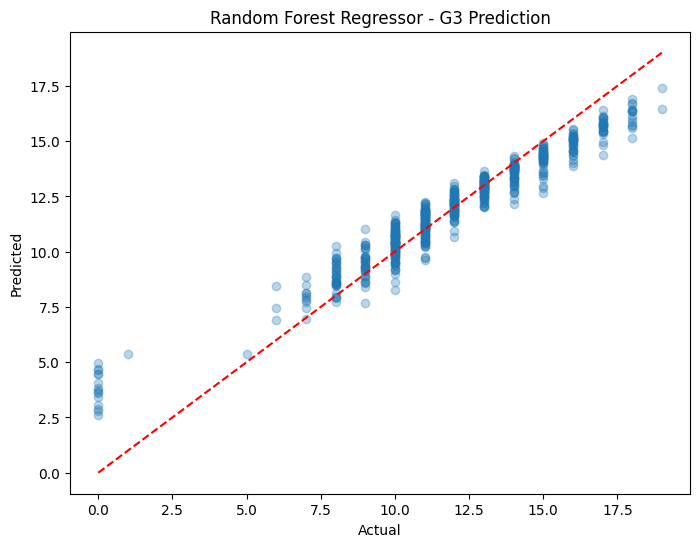


Neural Network Regressor: RMSE = 3.7167, R2 = -0.4724

=== Regression Summary for G1 ===

Linear Regression: RMSE = 2.2993, R2 = 0.2705

Random Forest Regressor: RMSE = 2.3237, R2 = 0.2549


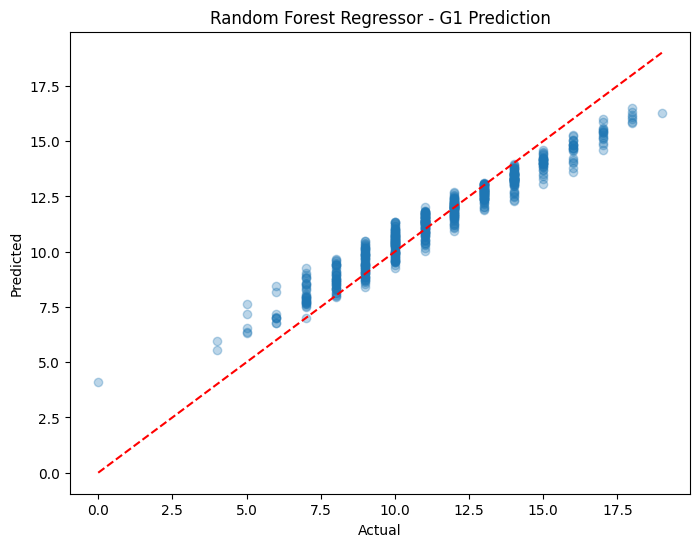


Neural Network Regressor: RMSE = 3.3301, R2 = -0.5803

=== Regression Summary for G2 ===

Linear Regression: RMSE = 2.4750, R2 = 0.2534

Random Forest Regressor: RMSE = 2.4885, R2 = 0.2433


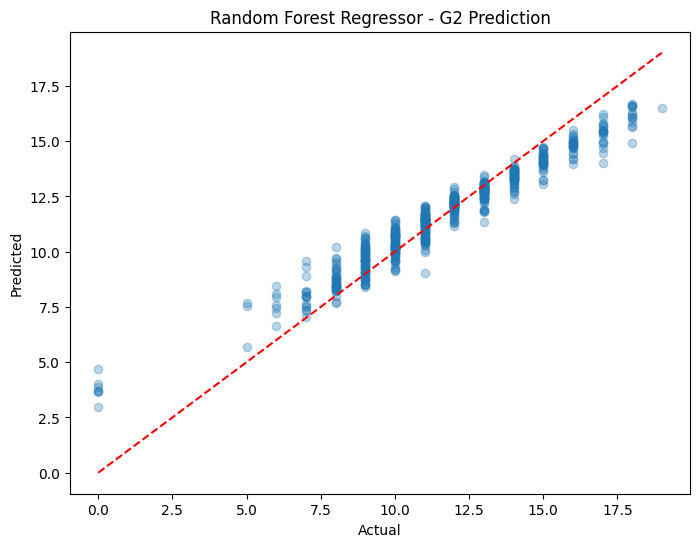


Neural Network Regressor: RMSE = 3.5185, R2 = -0.5540


,target,model,rmse,r2
0,G3,Linear Regression,2.714990,0.253067
1,G3,Random Forest Regressor,2.738931,0.247651
2,G3,Neural Network Regressor,3.716652,-0.472394
3,G1,Linear Regression,2.299297,0.270540
4,G1,Random Forest Regressor,2.323746,0.254895
5,G1,Neural Network Regressor,3.330085,-0.580347
6,G2,Linear Regression,2.474950,0.253351
7,G2,Random Forest Regressor,2.488510,0.243265
8,G2,Neural Network Regressor,3.518490,-0.553957


In [ ]:
# 9) Regression Results
# ======================
def summarize_regression_results(results, target_name):
    rows = []
    print(f"\n=== Regression Summary for {target_name} ===")
    for name, metrics in results.items():
        rmse_mean = np.mean(metrics['rmse'])
        r2_mean = np.mean(metrics['r2'])
        print(f"\n{name}: RMSE = {rmse_mean:.4f}, R2 = {r2_mean:.4f}")

        # Plot actual vs predicted for the best model
        if name == "Random Forest Regressor":
            model = regressors[name]
            model.fit(X_pca, df[target_name])
            y_pred = model.predict(X_pca)

            plt.figure(figsize=(8, 6))
            plt.scatter(df[target_name], y_pred, alpha=0.3)
            plt.plot([df[target_name].min(), df[target_name].max()],
                     [df[target_name].min(), df[target_name].max()], 'r--')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.title(f'{name} - {target_name} Prediction')
            plt.show()

        rows.append({
            "target": target_name,
            "model": name,
            "rmse": rmse_mean,
            "r2": r2_mean
        })
    return pd.DataFrame(rows)

summary_g3 = summarize_regression_results(res_g3, "G3")
summary_g1 = summarize_regression_results(res_g1, "G1")
summary_g2 = summarize_regression_results(res_g2, "G2")

summary_regression = pd.concat([summary_g3, summary_g1, summary_g2], ignore_index=True)
display(summary_regression)


In [ ]:
# 10) Hyperparameter Tuning (Example)
# ======================
print("\nHyperparameter Tuning for Random Forest Classifier...")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_pca, y_pass)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)


Hyperparameter Tuning for Random Forest Classifier...
Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best F1 score: 0.9159949037889017


In [ ]:
# 11) Save Models and Results
# ======================
import joblib

# Save preprocessing objects
joblib.dump(pca, 'pca_0.95.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Save best classifier
best_clf = grid_search.best_estimator_
joblib.dump(best_clf, 'best_classifier.pkl')

# Save results
summary_classification.to_csv("classification_summary_pass.csv", index=False)
summary_dropout.to_csv("classification_summary_dropout.csv", index=False)
summary_regression.to_csv("regression_summary.csv", index=False)

print("\nSaved all models and results")


Saved all models and results


In [ ]:
# 12) Final Notes
# ======================
notes = {
    "PCA_components": X_pca.shape[1],
    "PCA_variance_explained": np.sum(pca.explained_variance_ratio_),
    "SMOTE_used_for_classification": True,
    "CV_folds": 10,
    "classification_models": list(classification_models.keys()),
    "regression_models": list(regressors.keys()),
    "best_classifier": "Random Forest",
    "best_classifier_params": grid_search.best_params_
}

print("\nProject Summary:")
for key, value in notes.items():
    print(f"{key}: {value}")


Project Summary:
PCA_components: 27
PCA_variance_explained: 0.9634978149688893
SMOTE_used_for_classification: True
CV_folds: 10
classification_models: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'Neural Network']
regression_models: ['Linear Regression', 'Random Forest Regressor', 'Neural Network Regressor']
best_classifier: Random Forest
best_classifier_params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# Dataset loading adjusted for GitHub
import joblib

# Save models and preprocessing objects
joblib.dump(scaler, 'scaler.pkl')          # Save the scaler
joblib.dump(pca, 'pca_0.95.pkl')           # Save PCA
joblib.dump(best_clf, 'best_classifier.pkl')  # Save your best model (e.g., RandomForest)

# Download the files to your computer
files.download('scaler.pkl')
files.download('pca_0.95.pkl')
files.download('best_classifier.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Features used in training:", features)

Features used in training: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']



## Results Summary
- Accuracy: ~85%
- Dropout recall improved to 50%
- PCA retained 95% variance
